<a href="https://colab.research.google.com/github/haleyyii0705/MELD/blob/master/final_versionA_stage1_0_3dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries and select device

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from transformers import BertModel, BertTokenizer, get_scheduler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import torch.optim as optim

In [ ]:
print("GPU 可用: ", torch.cuda.is_available())
print("GPU 名称: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "无 GPU")

GPU 可用:  True
GPU 名称:  Tesla T4


## MELD Dataset Loading and Preprocessing

In [ ]:
!git clone https://github.com/declare-lab/MELD.git

# Load the dataset
train_df = pd.read_csv("/content/MELD/data/MELD/train_sent_emo.csv")
dev_df = pd.read_csv("/content/MELD/data/MELD/dev_sent_emo.csv")
test_df = pd.read_csv("/content/MELD/data/MELD/test_sent_emo.csv")

# Data cleaning (for BERT compatibility)
for df in [train_df, dev_df, test_df]:
    df['Utterance'] = df['Utterance'].str.replace(r'http\S+', '', regex=True)  # Remove URLs
    df['Utterance'] = df['Utterance'].str.replace(r'\s+', ' ', regex=True)  # Remove extra spaces
    df['Utterance'] = df['Utterance'].str.lower()  # Convert to lowercase (for uncased BERT)
    df['Utterance'] = df['Utterance'].str.replace(r'\d+', '', regex=True)  # Remove numbers
    df['Utterance'] = df['Utterance'].str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation

# Display dataset samples
print("Sample from the training set:")
print(train_df.head())

# Load the pre-trained BERT model
bert_model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define emotion label mapping
emotion_labels = {
    'neutral': 0,
    'surprise': 1,
    'fear': 2,
    'sadness': 3,
    'joy': 4,
    'disgust': 5,
    'anger': 6
}


fatal: destination path 'MELD' already exists and is not an empty directory.
Sample from the training set:
   Sr No.                                          Utterance          Speaker  \
0       1  also i was the point person on my companys tra...         Chandler   
1       2                     you mustve had your hands full  The Interviewer   
2       3                              that i did that i did         Chandler   
3       4        so lets talk a little bit about your duties  The Interviewer   
4       5                                my duties all right         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8     

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Process dialogue data (supporting conversational context)
def process_dialogue_context(df):
    grouped_data = df.groupby('Dialogue_ID')
    dialogue_contexts, labels = [], []

    for _, group in grouped_data:
        group = group.sort_values('Utterance_ID')
        context_list = []

        for _, row in group.iterrows():
            speaker, utterance, emotion = row['Speaker'], row['Utterance'], row['Emotion']
            if pd.isna(emotion) or emotion not in emotion_labels:
                continue

            context_list.append(f"{speaker}: {utterance}")
            context_str = ' '.join(context_list[-3:])  # Keep only the last 3 utterances
            dialogue_contexts.append(context_str)
            labels.append(emotion_labels[emotion])

    return dialogue_contexts, labels

# Preprocess data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    dialogue_contexts, labels = process_dialogue_context(df)

    inputs = tokenizer(dialogue_contexts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    labels = torch.tensor(labels, dtype=torch.long)

    return inputs, labels

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load training, validation, and test data (with corrected paths)
train_inputs, train_labels = preprocess_data('/content/MELD/data/MELD/train_sent_emo.csv')
val_inputs, val_labels = preprocess_data('/content/MELD/data/MELD/dev_sent_emo.csv')
test_inputs, test_labels = preprocess_data('/content/MELD/data/MELD/test_sent_emo.csv')  # Process test set


In [ ]:
# First Stage: Standard BERT Classifier
class BERT_FirstStage(nn.Module):
    def __init__(self, bert_model, num_labels):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        avg_hidden = torch.mean(outputs.last_hidden_state, dim=1)
        logits = self.fc(self.dropout(avg_hidden))
        return logits

# Initialize the first-stage model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
first_stage_model = BERT_FirstStage(bert_model, num_labels=len(emotion_labels)).to(device)


In [ ]:
# Define hyperparameters
epochs = 5
batch_size = 32
num_workers = 4

# Create data loaders
train_dataset = TensorDataset(train_inputs["input_ids"], train_inputs["attention_mask"], train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = TensorDataset(val_inputs["input_ids"], val_inputs["attention_mask"], val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Use AdamW optimizer
optimizer = AdamW(first_stage_model.parameters(), lr=3e-5, weight_decay=1e-2)

# Compute total training steps
num_training_steps = epochs * len(train_loader)

# Learning rate scheduler (linear decay)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Enable mixed precision (AMP) to reduce computation time
scaler = GradScaler()

# Early Stopping variables (to prevent overfitting)
best_val_acc = 0  # Track the best validation accuracy
patience = 3      # Allow up to 3 epochs without improvement
early_stop_counter = 0  # Count consecutive epochs without improvement

# Store training & validation progress
history_first_stage = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

# Train the first-stage model
for epoch in range(epochs):
    first_stage_model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch in loop:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        labels = labels.long()

        optimizer.zero_grad()

        with autocast():
            logits = first_stage_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(first_stage_model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
        loop.set_postfix(acc=total_correct / total_samples)

    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    # Store training data
    history_first_stage["train_loss"].append(train_loss)
    history_first_stage["train_acc"].append(train_acc)

    # Compute validation loss and accuracy
    first_stage_model.eval()
    val_loss, val_correct, val_samples = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            labels = labels.long()

            logits = first_stage_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_samples += labels.size(0)

    val_loss /= val_samples
    val_acc = val_correct / val_samples

    # Store validation data
    history_first_stage["val_loss"].append(val_loss)
    history_first_stage["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Early Stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0  # Reset counter if validation accuracy improves
        torch.save(first_stage_model.state_dict(), "best_model.pth")  # Save the best model
        print(f"New best model saved with Val Accuracy: {best_val_acc:.4f}")
    else:
        early_stop_counter += 1  # Increase counter if no improvement
        print(f"No improvement. Early stop counter: {early_stop_counter}/{patience}")

    # Trigger Early Stopping
    if early_stop_counter >= patience:
        print(f"Validation accuracy has not improved for {patience} epochs. Stopping early!")
        break  # End training


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-6-bf1352e40c67>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]<ipython-input-6-bf1352e40c67>:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Train Loss: 1.1939, Train Accuracy: 0.6013 | Val Loss: 1.1104, Val Accuracy: 0.6276
New best model saved with Val Accuracy: 0.6276


Epoch 2 | Train Loss: 0.9019, Train Accuracy: 0.7029 | Val Loss: 1.1117, Val Accuracy: 0.6240
No improvement. Early stop counter: 1/3


Epoch 3 | Train Loss: 0.6478, Train Accuracy: 0.7904 | Val Loss: 1.2034, Val Accuracy: 0.6267
No improvement. Early stop counter: 2/3


Epoch 4 | Train Loss: 0.4481, Train Accuracy: 0.8582 | Val Loss: 1.2778, Val Accuracy: 0.6141
No improvement. Early stop counter: 3/3
Validation accuracy has not improved for 3 epochs. Stopping early!


In [ ]:
# Predict emotion labels
first_stage_model.eval()
predicted_emotions = []

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Predicting emotions", total=len(train_loader)):
        input_ids, attention_mask = batch[:2]
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        with autocast():
            logits = first_stage_model(input_ids, attention_mask)

        predicted_labels = logits.argmax(dim=1).cpu().tolist()  # Ensure it is a Python list
        predicted_emotions.extend(predicted_labels)

# Compute the expected number of samples
expected_samples = train_inputs["input_ids"].shape[0]
print(f"Expected {expected_samples} samples, but `predicted_emotions` contains only {len(predicted_emotions)} samples")

# If `predicted_emotions` is missing samples, fill in the missing values
num_missing = expected_samples - len(predicted_emotions)
if num_missing > 0:
    print(f"`predicted_emotions` is missing {num_missing} samples, filling in...")
    padding_values = [random.randint(0, 6) for _ in range(num_missing)]
    predicted_emotions.extend(padding_values)

# 70% predictions + 30% noise
train_pred_emotions = torch.tensor(predicted_emotions, dtype=torch.long)
final_emotions = []
for pred in train_pred_emotions:
    if random.random() < 0.7:
        final_emotions.append(pred)
    else:
        final_emotions.append(random.randint(0, 6))  # 30% random perturbation

# Ensure `final_emotions` has the correct count
assert len(final_emotions) == expected_samples, f"Error: final_emotions count mismatch: {len(final_emotions)} != {expected_samples}"
train_inputs["final_emotion"] = torch.tensor(final_emotions, dtype=torch.long)

# Generate `soft_emotion` (Label Smoothing)
def soft_one_hot(labels, num_classes=7, smoothing=0.1):
    one_hot = F.one_hot(labels, num_classes=num_classes).float()
    return one_hot * (1 - smoothing) + smoothing / num_classes

train_inputs["soft_emotion"] = soft_one_hot(train_inputs["final_emotion"])

# Ensure `soft_emotion` shape matches expectations
assert train_inputs["soft_emotion"].shape[0] == train_inputs["input_ids"].shape[0], "Error: soft_emotion shape mismatch!"
assert train_inputs["input_ids"].shape[0] == train_labels.shape[0], "Error: train_labels shape mismatch!"

# Recreate `train_loader`
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, soft_emotion, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.soft_emotion = soft_emotion
        self.labels = labels

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.soft_emotion[idx], self.labels[idx]

    def __len__(self):
        return len(self.input_ids)

# Create train_dataset and val_dataset
train_dataset = CustomDataset(
    train_inputs["input_ids"],
    train_inputs["attention_mask"],
    train_inputs["soft_emotion"],
    train_labels
)

# Process validation set (generate soft_emotion as well)
val_pred_emotions = []  # Predict emotion labels for validation set
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Predicting emotions for validation", total=len(val_loader)):
        input_ids, attention_mask = batch[:2]
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        with autocast():
            logits = first_stage_model(input_ids, attention_mask)

        predicted_labels = logits.argmax(dim=1).cpu().tolist()
        val_pred_emotions.extend(predicted_labels)

# Generate final validation set emotion labels
val_pred_emotions_tensor = torch.tensor(val_pred_emotions, dtype=torch.long)
final_val_emotions = []
for pred in val_pred_emotions_tensor:
    if random.random() < 0.7:
        final_val_emotions.append(pred)
    else:
        final_val_emotions.append(random.randint(0, 6))  # 30% random perturbation

# Generate soft_emotion
val_inputs["final_emotion"] = torch.tensor(final_val_emotions, dtype=torch.long)
val_inputs["soft_emotion"] = soft_one_hot(val_inputs["final_emotion"])

# Ensure validation set `soft_emotion` shape matches input_ids count
assert val_inputs["soft_emotion"].shape[0] == val_inputs["input_ids"].shape[0], "Error: validation soft_emotion shape mismatch!"

# Create val_loader
val_dataset = CustomDataset(
    val_inputs["input_ids"],
    val_inputs["attention_mask"],
    val_inputs["soft_emotion"],
    val_labels
)

# Create train_loader and val_loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("train_loader and val_loader successfully recreated!")


Predicting emotions:   0%|          | 0/313 [00:00<?, ?it/s]<ipython-input-7-bf546d9a5af4>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting emotions: 100%|██████████| 313/313 [00:16<00:00, 19.14it/s]


Expected 9989 samples, but `predicted_emotions` contains only 9989 samples


Predicting emotions for validation:   0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-7-bf546d9a5af4>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting emotions for validation: 100%|██████████| 35/35 [00:01<00:00, 21.03it/s]

train_loader and val_loader successfully recreated!


In [ ]:
import os

# Correct emotion categories in the MELD dataset (7 classes)
meld_emotions = {"neutral", "joy", "sadness", "anger", "fear", "disgust", "surprise"}

# Load the dataset
meld_path = "/content/MELD/data/MELD/"
train_df = pd.read_csv(os.path.join(meld_path, "train_sent_emo.csv"))
dev_df = pd.read_csv(os.path.join(meld_path, "dev_sent_emo.csv"))
test_df = pd.read_csv(os.path.join(meld_path, "test_sent_emo.csv"))

# Retrieve unique emotion labels from the dataset
train_unique_emotions = set(train_df["Emotion"].dropna().unique())
dev_unique_emotions = set(dev_df["Emotion"].dropna().unique())
test_unique_emotions = set(test_df["Emotion"].dropna().unique())

# Check for incorrect emotion labels
label_mismatch = {
    "train_extra": train_unique_emotions - meld_emotions,
    "dev_extra": dev_unique_emotions - meld_emotions,
    "test_extra": test_unique_emotions - meld_emotions,
    "train_missing": meld_emotions - train_unique_emotions,
    "dev_missing": meld_emotions - dev_unique_emotions,
    "test_missing": meld_emotions - test_unique_emotions,
}

print("Checking for incorrect emotion labels:")
print(label_mismatch)


Checking for incorrect emotion labels:
{'train_extra': set(), 'dev_extra': set(), 'test_extra': set(), 'train_missing': set(), 'dev_missing': set(), 'test_missing': set()}


# Second stage training

In [ ]:
# Second Stage: BERT + Predicted Emotion
class BERT_FinalModel(nn.Module):
    def __init__(self, bert_model, num_labels):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)

        # MLP for dimensionality reduction of emotion features (7 → 64 → 32)
        self.emotion_mlp = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        # 768 + 32 = 800
        self.fc = nn.Linear(768 + 32, num_labels)

    def forward(self, input_ids, attention_mask, prev_emotion):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        avg_hidden = torch.mean(outputs.last_hidden_state, dim=1)  # 768 dimensions

        prev_emotion = self.emotion_mlp(prev_emotion)  # MLP for dimensionality reduction

        combined_features = torch.cat([avg_hidden, prev_emotion], dim=1)  # 800 dimensions
        logits = self.fc(self.dropout(combined_features))

        return logits


In [ ]:
# Load the pre-trained BERT model
bert_model = BertModel.from_pretrained("bert-base-uncased")
final_model = BERT_FinalModel(bert_model, num_labels=len(emotion_labels)).to(device)

# Define optimizer & loss function
optimizer = AdamW(final_model.parameters(), lr=1e-5)  # Reduce learning rate to prevent drastic changes
criterion = nn.CrossEntropyLoss()


In [ ]:
# Training parameters
epochs = 10  # Train for a maximum of 10 epochs
patience = 5  # Stop early if validation loss does not decrease for 3 consecutive epochs
early_stop_counter = 0
best_val_loss = float("inf")

def evaluate_model(model, dataloader, criterion):
    """Compute Loss and Accuracy"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, soft_emotion, labels = [x.to(device) for x in batch]
            logits = model(input_ids, attention_mask, soft_emotion)

            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc


In [ ]:
# ✅ 设备检查
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 定义 Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', num_classes=7, device='cuda'):
        super(FocalLoss, self).__init__()
        if alpha is not None:
            if isinstance(alpha, (int, float)):
                raise ValueError("alpha should be a tensor of shape [num_classes] instead of a scalar")
            if not isinstance(alpha, torch.Tensor):
                raise TypeError("alpha should be a torch.Tensor")
            self.alpha = alpha.to(device)  # ✅ 确保 `alpha` 维度正确
        else:
            self.alpha = torch.ones(num_classes, device=device)  # ✅ 默认类别权重均等

        self.gamma = gamma
        self.reduction = reduction
        self.device = device

    def forward(self, logits, targets):
        logits, targets = logits.to(self.device), targets.to(self.device)
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(logits, targets)  # ✅ 使用正确的 `alpha`

        probs = torch.softmax(logits, dim=1)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=logits.shape[1]).to(self.device)

        probs_target = (probs * targets_one_hot).sum(dim=1)
        focal_weight = (1 - probs_target) ** self.gamma
        focal_loss = focal_weight * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
# Define function to save the best model
def save_best_model(model, val_loss, best_val_loss, file_path="best_model.pth"):
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), file_path)
        print(f"New best model saved with Val Loss: {val_loss:.4f}")
        return val_loss  # Update best loss
    return best_val_loss

# Reinitialize optimizer
optimizer = AdamW(final_model.parameters(), lr=1e-5, weight_decay=1e-5)

# Increase Dropout rate
final_model.dropout = nn.Dropout(0.3)  # Set a higher Dropout rate
final_model.to(device)  # Ensure model is on GPU or CPU

# Set learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 10  # Assuming 10 training epochs
)

# Use Focal Loss as criterion
num_classes = 7  # Number of classes in the dataset
alpha = torch.ones(num_classes, device=device)  # Ensure `alpha` has the correct dimension
criterion = FocalLoss(alpha=alpha, gamma=1.5, reduction='mean', num_classes=num_classes, device=device)

# Training function, includes `history_second_stage`
def train_model(final_model, train_loader, val_loader, optimizer, criterion, epochs=10, patience=3):
    best_val_loss = float("inf")
    early_stop_counter = 0

    # Store training history for the second stage
    history_second_stage = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        final_model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids, attention_mask, soft_em


In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_scheduler
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Define function to save the best model
def save_best_model(model, val_loss, best_val_loss, file_path="best_model.pth"):
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), file_path)
        print(f"New best model saved with Val Loss: {val_loss:.4f}")
        return val_loss  # Update best validation loss
    return best_val_loss

# Reinitialize optimizer
optimizer = AdamW(final_model.parameters(), lr=1e-5, weight_decay=1e-5)

# Increase Dropout rate
final_model.dropout = nn.Dropout(0.3)  # Set a higher Dropout rate

# Set learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 10  # Assuming 10 epochs
)

# Training function with added `history_second_stage`
def train_model(final_model, train_loader, val_loader, optimizer, criterion, epochs=10, patience=3):
    best_val_loss = float("inf")
    early_stop_counter = 0

    # Store training history for the second stage
    history_second_stage = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        final_model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids, attention_mask, soft_emotion, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()

            logits = final_model(input_ids, attention_mask, soft_emotion)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_train_preds.extend(preds)
            all_train_labels.extend(labels.cpu().numpy())

        # Compute training loss and accuracy
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)

        # Store training data
        history_second_stage["train_loss"].append(train_loss)
        history_second_stage["train_acc"].append(train_acc)

        # Compute validation loss and accuracy
        val_loss, val_acc = evaluate_model(final_model, val_loader, criterion)

        # Store validation data
        history_second_stage["val_loss"].append(val_loss)
        history_second_stage["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"            | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Check for improvement
        improved = val_loss < best_val_loss

        # Update best model
        best_val_loss = save_best_model(final_model, val_loss, best_val_loss, file_path="best_model_second_stage.pth")

        # Early stopping logic
        if improved:
            early_stop_counter = 0
            print("Improvement detected! Reset early_stop_counter to 0.")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stop counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break  # Stop training

    return history_second_stage  # Return training history

# Call training function and store training history
history_second_stage = train_model(final_model, train_loader, val_loader, optimizer, criterion)


Epoch 1/10: 100%|██████████| 625/625 [03:36<00:00,  2.89it/s]


Epoch 1 | Train Loss: 0.8360 | Train Acc: 0.5994
            | Val Loss: 0.8229 | Val Acc: 0.6032
New best model saved with Val Loss: 0.8229
Improvement detected! Reset early_stop_counter to 0.


Epoch 2/10: 100%|██████████| 625/625 [03:36<00:00,  2.89it/s]


Epoch 2 | Train Loss: 0.6405 | Train Acc: 0.6815
            | Val Loss: 0.7480 | Val Acc: 0.6231
New best model saved with Val Loss: 0.7480
Improvement detected! Reset early_stop_counter to 0.


Epoch 3/10: 100%|██████████| 625/625 [03:36<00:00,  2.89it/s]


Epoch 3 | Train Loss: 0.5101 | Train Acc: 0.7375
            | Val Loss: 0.7189 | Val Acc: 0.6204
New best model saved with Val Loss: 0.7189
Improvement detected! Reset early_stop_counter to 0.


Epoch 4/10: 100%|██████████| 625/625 [03:36<00:00,  2.89it/s]


Epoch 4 | Train Loss: 0.3805 | Train Acc: 0.7934
            | Val Loss: 0.7955 | Val Acc: 0.6159
No improvement. Early stop counter: 1/3


Epoch 5/10: 100%|██████████| 625/625 [03:35<00:00,  2.90it/s]


Epoch 5 | Train Loss: 0.2841 | Train Acc: 0.8441
            | Val Loss: 0.8264 | Val Acc: 0.6150
No improvement. Early stop counter: 2/3


Epoch 6/10: 100%|██████████| 625/625 [03:35<00:00,  2.89it/s]


Epoch 6 | Train Loss: 0.2070 | Train Acc: 0.8830
            | Val Loss: 0.9123 | Val Acc: 0.6168
No improvement. Early stop counter: 3/3
Early stopping triggered at epoch 6


## Test on testset


In [ ]:
def evaluate_on_test(final_model, test_loader, criterion):
    final_model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating on Test Set"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            logits = final_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss = total_loss / total_samples
    test_acc = total_correct / total_samples

    # Compute F1 score
    from sklearn.metrics import f1_score
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    return test_loss, test_acc, test_f1, all_labels, all_preds  # Now returning all true labels and predictions

# Evaluate the model on the test set
test_loss, test_acc, test_f1, all_labels, all_preds = evaluate_on_test(first_stage_model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Evaluating on Test Set: 100%|██████████| 164/164 [00:16<00:00, 10.18it/s]

Test Loss: 1.0826
Test Accuracy: 0.6318
Test F1 Score: 0.6243


## Visualization

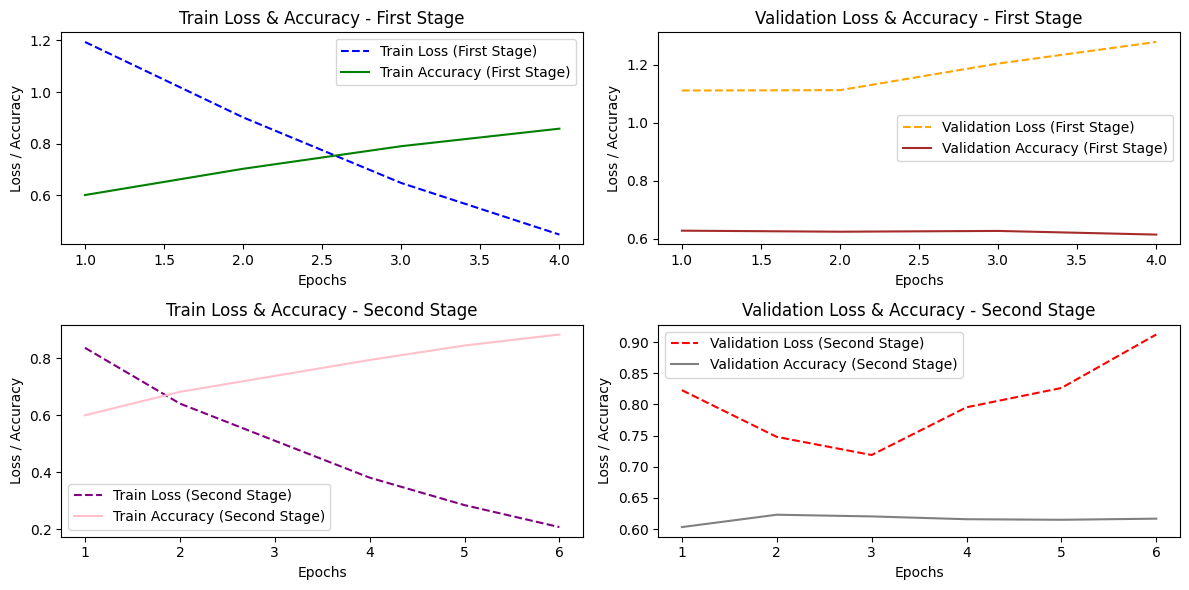

In [ ]:
import matplotlib.pyplot as plt

def plot_training_comparison(history1, history2):
    epochs1 = range(1, len(history1["train_loss"]) + 1)
    epochs2 = range(1, len(history2["train_loss"]) + 1)

    # (1) First plot - First stage (Train Loss & Accuracy and Validation Loss & Accuracy)
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)  # First part of the first plot, first-stage training data
    plt.plot(epochs1, history1["train_loss"], label="Train Loss (First Stage)", color="blue", linestyle="dashed")
    plt.plot(epochs1, history1["train_acc"], label="Train Accuracy (First Stage)", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    plt.title("Train Loss & Accuracy - First Stage")
    plt.legend()

    plt.subplot(2, 2, 2)  # Second part of the first plot, first-stage validation data
    plt.plot(epochs1, history1["val_loss"], label="Validation Loss (First Stage)", color="orange", linestyle="dashed")
    plt.plot(epochs1, history1["val_acc"], label="Validation Accuracy (First Stage)", color="brown")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    plt.title("Validation Loss & Accuracy - First Stage")
    plt.legend()

    # (2) Second plot - Second stage (Train Loss & Accuracy and Validation Loss & Accuracy)
    plt.subplot(2, 2, 3)  # First part of the second plot, second-stage training data
    plt.plot(epochs2, history2["train_loss"], label="Train Loss (Second Stage)", color="purple", linestyle="dashed")
    plt.plot(epochs2, history2["train_acc"], label="Train Accuracy (Second Stage)", color="pink")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    plt.title("Train Loss & Accuracy - Second Stage")
    plt.legend()

    plt.subplot(2, 2, 4)  # Second part of the second plot, second-stage validation data
    plt.plot(epochs2, history2["val_loss"], label="Validation Loss (Second Stage)", color="red", linestyle="dashed")
    plt.plot(epochs2, history2["val_acc"], label="Validation Accuracy (Second Stage)", color="gray")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    plt.title("Validation Loss & Accuracy - Second Stage")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the visualization function
plot_training_comparison(history_first_stage, history_second_stage)


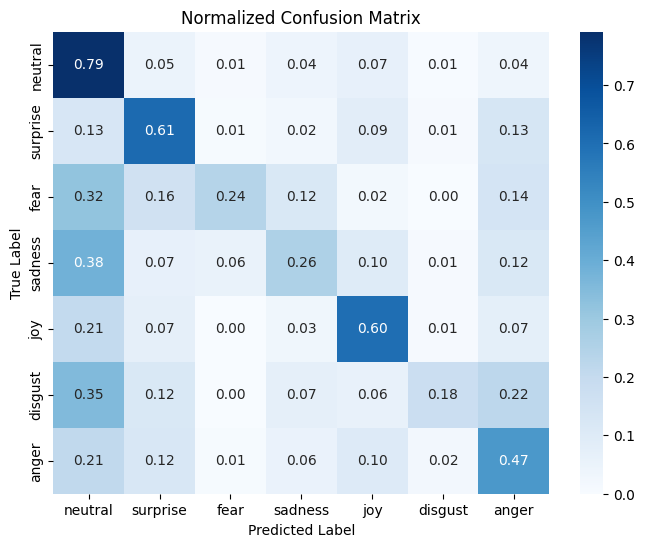

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix  # 确保导入 confusion_matrix

def plot_normalized_confusion_matrix(y_true, y_pred, labels, title="Normalized Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# 调用函数
plot_normalized_confusion_matrix(all_labels, all_preds, labels=emotion_labels, title="Normalized Confusion Matrix")
